In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
import math

## Load Dataset

In [23]:
df = pd.read_csv("../DataSets/bitcoin_prices5.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df_chart = df.copy()
df

,timestamp,-1min,sma7,sma25,sma50,ema7,ema25,ema50,price
0,2023-04-13 12:27:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30216.29
1,2023-04-13 12:28:00,30216.29,NaN,NaN,NaN,NaN,NaN,NaN,30213.57
2,2023-04-13 12:29:00,30213.57,NaN,NaN,NaN,NaN,NaN,NaN,30214.46
3,2023-04-13 12:30:00,30214.46,NaN,NaN,NaN,NaN,NaN,NaN,30256.32
4,2023-04-13 12:31:00,30256.32,NaN,NaN,NaN,NaN,NaN,NaN,30237.66
...,...,...,...,...,...,...,...,...,...
1996,2023-04-14 21:43:00,30512.85,30513.616485,30486.927322,30452.803016,30518.259932,30503.266014,30486.248963,30516.24
1997,2023-04-14 21:44:00,30516.24,30513.265558,30487.896629,30453.970156,30516.484949,30503.873244,30487.225866,30511.16
1998,2023-04-14 21:45:00,30511.16,30512.064764,30488.575164,30454.987953,30513.578712,30503.949148,30487.917401,30504.86
1999,2023-04-14 21:46:00,30504.86,30510.682655,30489.127758,30455.935994,30510.781534,30503.829213,30488.484954,30502.39


## Dataset Summary

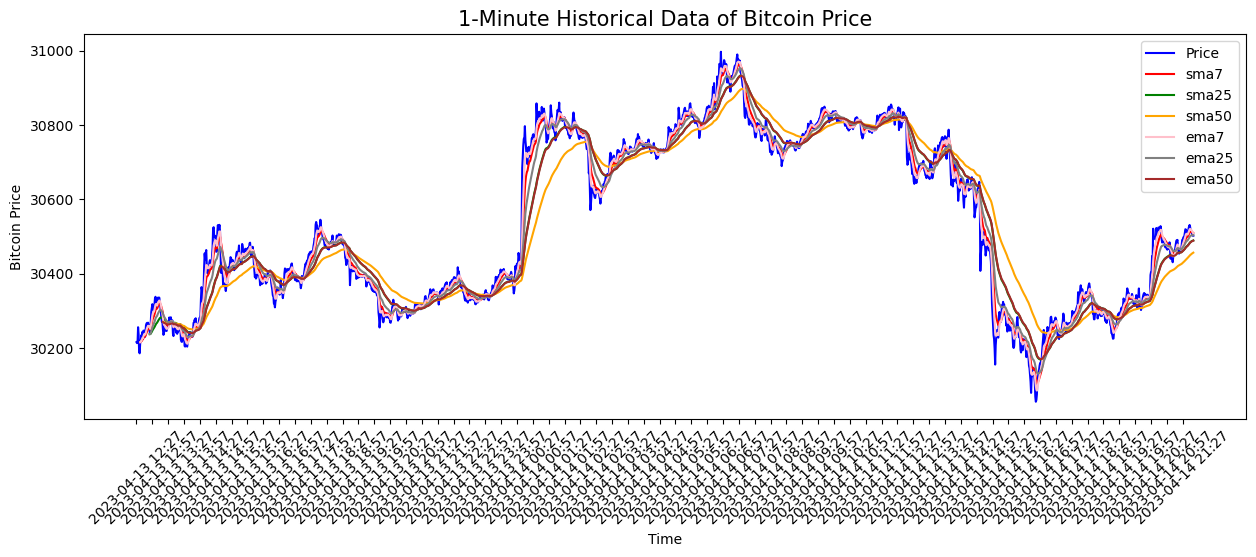

In [3]:
df_chart['timestamp'] = pd.to_datetime(df_chart['timestamp'])
df_chart.set_index('timestamp', inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df_chart.index, df_chart['price'], color='blue', label='Price')
plt.plot(df_chart.index, df_chart['sma7'], color='red', label='sma7')
plt.plot(df_chart.index, df_chart['sma25'], color='green', label='sma25')
plt.plot(df_chart.index, df_chart['sma50'], color='orange', label='sma50')
plt.plot(df_chart.index, df_chart['ema7'], color='pink', label='ema7')
plt.plot(df_chart.index, df_chart['ema25'], color='gray', label='ema25')
plt.plot(df_chart.index, df_chart['ema50'], color='brown', label='ema50')
plt.title('1-Minute Historical Data of Bitcoin Price', fontsize=15)
plt.ylabel('Bitcoin Price')
plt.xlabel('Time')
plt.legend()

tick_values = pd.date_range(start=df_chart.index[0], end=df_chart.index[-1], freq='30T')
tick_labels = [date.strftime('%Y-%m-%d %H:%M') for date in tick_values]
plt.xticks(tick_values, tick_labels, rotation=45)

plt.show()

In [4]:
#drop NAN rows
df = df.drop(df.index[:50])

feature_df = df.iloc[:,1:9]

In [5]:
feature_df

,-1min,sma7,sma25,sma50,ema7,ema25,ema50,price
50,30271.42,30293.747671,30280.362618,30270.983772,30282.120339,30293.132637,30270.592129,30251.01
51,30251.01,30285.473718,30278.581314,30270.280697,30270.547754,30288.724741,30269.228909,30235.83
52,30235.83,30278.997473,30277.043661,30269.677883,30262.945815,30284.987454,30268.088167,30240.14
53,30240.14,30276.200691,30276.338715,30269.472725,30262.064362,30283.020726,30267.748239,30259.42
54,30259.42,30272.376306,30275.262366,30269.071870,30258.905771,30280.436824,30267.029877,30249.43
...,...,...,...,...,...,...,...,...
1996,30512.85,30513.616485,30486.927322,30452.803016,30518.259932,30503.266014,30486.248963,30516.24
1997,30516.24,30513.265558,30487.896629,30453.970156,30516.484949,30503.873244,30487.225866,30511.16
1998,30511.16,30512.064764,30488.575164,30454.987953,30513.578712,30503.949148,30487.917401,30504.86
1999,30504.86,30510.682655,30489.127758,30455.935994,30510.781534,30503.829213,30488.484954,30502.39


In [6]:
#Feature Scaling using StandardScaler
scaler = StandardScaler()
df_ft = scaler.fit_transform(feature_df.values)
df_ft = pd.DataFrame(columns=feature_df. columns,
                    data=df_ft,
                    index=feature_df.index)

In [7]:
df_ft

,-1min,sma7,sma25,sma50,ema7,ema25,ema50,price
50,-1.199563,-1.105050,-1.179454,-1.248539,-1.155213,-1.112024,-1.223393,-1.291905
51,-1.290908,-1.142342,-1.187640,-1.251865,-1.207209,-1.132017,-1.229657,-1.359868
52,-1.358846,-1.171532,-1.194707,-1.254716,-1.241365,-1.148969,-1.234899,-1.340572
53,-1.339557,-1.184138,-1.197946,-1.255687,-1.245325,-1.157890,-1.236461,-1.254253
54,-1.253269,-1.201375,-1.202893,-1.257583,-1.259517,-1.169611,-1.239762,-1.298979
...,...,...,...,...,...,...,...,...
1996,-0.119037,-0.114066,-0.230147,-0.388410,-0.094234,-0.158876,-0.232436,-0.104433
1997,-0.103865,-0.115648,-0.225692,-0.382889,-0.102209,-0.156121,-0.227947,-0.127177
1998,-0.126601,-0.121060,-0.222574,-0.378074,-0.115267,-0.155777,-0.224769,-0.155383
1999,-0.154797,-0.127289,-0.220035,-0.373589,-0.127835,-0.156321,-0.222161,-0.166441


In [8]:
def lstm_split(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps + 1):
        X.append (data[i:i + n_steps, : - 1])
        y.append(data[i + n_steps - 1, - 1])
    return np.array(X), np.array(y)

In [9]:
X1, y1 = lstm_split(df_ft.values, n_steps=50)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [19]:
print(X_train.shape, y_train.shape)

(1331, 50, 7) (1331,)


array([[[ 1.15160795,  1.16176739,  1.23423891, ...,  1.1559654 ,
          1.18984658,  1.23516596],
        [ 1.18141492,  1.16701211,  1.23410273, ...,  1.16530662,
          1.19131945,  1.23502082],
        [ 1.18772541,  1.17898304,  1.23610623, ...,  1.18535351,
          1.19672994,  1.23697348],
        ...,
        [ 1.2181142 ,  1.18777059,  1.19518502, ...,  1.20737466,
          1.17656739,  1.19603379],
        [ 1.20509043,  1.19852737,  1.19924524, ...,  1.2199598 ,
          1.18406171,  1.20000549],
        [ 1.25185963,  1.21320758,  1.2047019 , ...,  1.23892385,
          1.19393836,  1.20534952]],

       [[ 1.22397713,  1.31448939,  1.28355615, ...,  1.32106671,
          1.2989113 ,  1.28312603],
        [ 1.38791549,  1.3303425 ,  1.29070483, ...,  1.34569969,
          1.30956602,  1.2901749 ],
        [ 1.41311268,  1.3414455 ,  1.29685799, ...,  1.35983866,
          1.31805433,  1.29625178],
        ...,
        [ 0.50601396,  0.65350419,  0.98930522, ...,  

## Sequential model

In [12]:
model = Sequential ()
model. add(LSTM(units = 100, return_sequences= True, input_shape = (X_train.shape[1], X_train.shape[2])))
model. add (Dropout (0.2))
model. add (LSTM(units = 50, return_sequences= True))
model. add (Dropout (0.2))
model. add(LSTM(units = 100, return_sequences= True))
model. add(Dropout (0.2))
model.add(LSTM(units = 50))
model.add(Dropout (0.2))
model.add(Dense (units=1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

## Summary

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           43200     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            30200     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 100)           60400     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                3

## Train

In [14]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
42/42 [==============================] - 34s 247ms/step - loss: 0.1451 - accuracy: 0.0000e+00
Epoch 2/50
42/42 [==============================] - 6s 133ms/step - loss: 0.0534 - accuracy: 0.0000e+00
Epoch 3/50
42/42 [==============================] - 5s 124ms/step - loss: 0.0460 - accuracy: 0.0000e+00
Epoch 4/50
42/42 [==============================] - 5s 115ms/step - loss: 0.0456 - accuracy: 0.0000e+00
Epoch 5/50
42/42 [==============================] - 5s 110ms/step - loss: 0.0380 - accuracy: 0.0000e+00
Epoch 6/50
42/42 [==============================] - 4s 102ms/step - loss: 0.0397 - accuracy: 0.0000e+00
Epoch 7/50
42/42 [==============================] - 4s 99ms/step - loss: 0.0403 - accuracy: 0.0000e+00
Epoch 8/50
42/42 [==============================] - 4s 99ms/step - loss: 0.0337 - accuracy: 0.0000e+00
Epoch 9/50
42/42 [==============================] - 4s 99ms/step - loss: 0.0317 - accuracy: 0.0000e+00
Epoch 10/50
42/42 [==============================] - 4s 97ms/step 

In [15]:
# model.save('model_006.h5')
# loaded_model = keras.models.load_model('model_006.h5')

## Evaluate

In [16]:
y_pred = model.predict(X_test)

18/18 [==============================] - 2s 35ms/step


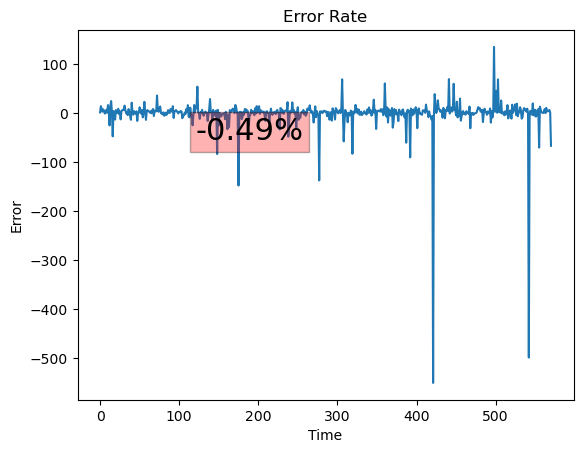

In [17]:
error_rates = (y_test.reshape(-1, 1) - y_pred) / y_test.reshape(-1, 1) * 100
average_error_rate = np.sum(error_rates)/len(error_rates)
plt.plot(error_rates)
plt.text(120,-55, f'{average_error_rate:.2f}%', fontsize = 22, bbox = dict(facecolor = 'red', alpha = 0.3))
plt.title('Error Rate')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

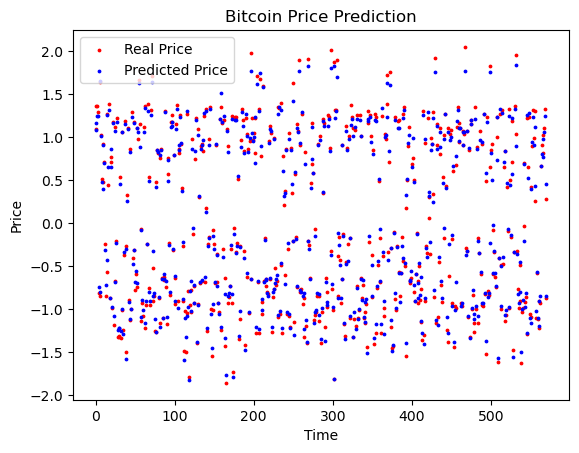

In [18]:
y_test_index = range(len(y_test))

y_test_series = pd.Series(y_test.reshape(-1,), index=y_test_index)
y_pred_series = pd.Series(y_pred.reshape(-1,), index=y_test_index)

plt.scatter(y_test_series.index, y_test_series, color='red', label='Real Price', s=3)
plt.scatter(y_pred_series.index, y_pred_series, color='blue', label='Predicted Price', s=3)
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()